# 🎯 Long-Text Uncertainty Quantification

<div style="background-color: rgba(200, 200, 200, 0.1); padding: 20px; border-radius: 8px; margin-bottom: 20px; border: 1px solid rgba(127, 127, 127, 0.2); max-width: 97.5%; overflow-wrap: break-word;">
  <p style="font-size: 16px; line-height: 1.6">
    Long-Text Uncertainty Quantification (LUQ) is a long-form adaptation of black-box uncertainty quantification. This approach generates multiple responses to the same prompt, decomposes those responses into granular units (sentences or claims), and scores those units by measuring whether sampled responses entail each unit. This demo provides an illustration 
    of how to use the LUQ methods with <code>uqlm</code>. The available scorers and papers from which they are adapted are below:
  </p>
      
*   Long-text Uncertainty Quantification (LUQ) ([Zhang et al., 2024](https://arxiv.org/abs/2403.20279))
*   LUQ-Atomic ([Zhang et al., 2024](https://arxiv.org/abs/2403.20279))
*   LUQ-pair ([Zhang et al., 2024](https://arxiv.org/abs/2403.20279))
*   Generalized LUQ-pair ([Zhang et al., 2024](https://arxiv.org/abs/2403.20279))

</div>

## 📊 What You'll Do in This Demo

<div style="display: flex; margin-bottom: 15px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>1</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section1>Set up LLM and prompts.</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Set up LLM instance and load example data prompts.</p>
  </div>
</div>

<div style="display: flex; margin-bottom: 15px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>2</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section2>Generate LLM Responses and Confidence Scores</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Generate responses and compute claim-level confidence scores using the <code>LongTextUQ()</code> class.</p>
  </div>
</div>

<div style="display: flex; margin-bottom: 25px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>3</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section3>Evaluate Hallucination Detection Performance</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Grade claims with `FactScoreGrader` class and evaluate claim-level hallucination detection.</p>
  </div>
</div>

## ⚖️ Advantages & Limitations

<div style="display: flex; gap: 20px">
  <div style="flex: 1; background-color: rgba(0, 200, 0, 0.1); padding: 15px; border-radius: 8px; border: 1px solid rgba(0, 200, 0, 0.2)">
    <h3 style="color: #2e8b57; margin-top: 0">Pros</h3>
    <ul style="margin-bottom: 0">
      <li><strong>Universal Compatibility:</strong> Works with any LLM without requiring token probability access</li>
      <li><strong>Fine-Grained Scoring:</strong> Score at sentence or claim-level to localize likely hallucinations</li>
      <li><strong>Uncertainty-aware decoding:</strong> Improve factual precision by dropping high-uncertainty claims</li>
    </ul>
  </div>
  
  <div style="flex: 1; background-color: rgba(200, 0, 0, 0.1); padding: 15px; border-radius: 8px; border: 1px solid rgba(200, 0, 0, 0.2)">
    <h3 style="color: #b22222; margin-top: 0">Cons</h3>
    <ul style="margin-bottom: 0">
      <li><strong>Higher Cost:</strong> Requires multiple generations per prompt</li>
      <li><strong>Slower:</strong> Multiple generations and comparison calculations increase latency</li>
    </ul>
  </div>
</div>

In [1]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

from uqlm import LongTextUQ
from uqlm.utils import load_example_dataset, plot_model_accuracies, LLMGrader, Tuner
from uqlm.longform import FactScoreGrader

<a id='section1'></a>
## 1. Set up LLM and Prompts

In this demo, we will illustrate this approach using the [FactScore](https://github.com/shmsw25/FActScore/tree/main/factscore) longform QA dataset. To implement with your use case, simply **replace the example prompts with your data**.  

In [2]:
# Load example dataset (FactScore)
factscore = load_example_dataset("factscore", n=10)[["hundredw_prompt", "wikipedia_text"]].rename(columns={"hundredw_prompt": "prompt"})
factscore.head()

Loading dataset - factscore...
Processing dataset...
Dataset ready!


,prompt,wikipedia_text
0,Tell me a bio of Suthida within 100 words.\n,Suthida Bajrasudhabimalalakshana (Thai: สมเด็จ...
1,Tell me a bio of Miguel Ángel Félix Gallardo w...,"Miguel Ángel Félix Gallardo (born January 8, 1..."
2,Tell me a bio of Iggy Azalea within 100 words.\n,"Amethyst Amelia Kelly (born 7 June 1990), know..."
3,Tell me a bio of Fernando da Costa Novaes with...,"Fernando da Costa Novaes (April 6, 1927 – Marc..."
4,Tell me a bio of Jan Zamoyski within 100 words.\n,Jan Sariusz Zamoyski (Latin: Ioannes Zamoyski ...


In this example, we use `AzureChatOpenAI` to instantiate our LLM, but any [LangChain Chat Model](https://js.langchain.com/docs/integrations/chat/) may be used. Be sure to **replace with your LLM of choice.**

In [3]:
# import sys
# !{sys.executable} -m pip install langchain-openai

## User to populate .env file with API credentials
from dotenv import load_dotenv, find_dotenv
from langchain_openai import AzureChatOpenAI

load_dotenv(find_dotenv())
llm = AzureChatOpenAI(
    deployment_name="gpt-4o",
    openai_api_type="azure",
    openai_api_version="2024-12-01-preview",
    temperature=1,  # User to set temperature
)

<a id='section2'></a>
## 2. Generate LLM Responses and Claim/Sentence-Level Confidence Scores

### `LongTextUQ()` - Generate long-text LLM responses, decompose into claims or sentences, and measure entailment among sampled responses.

![Sample Image](https://raw.githubusercontent.com/cvs-health/uqlm/longform-uq-resolved/assets/images/unit_response_graphic.png)

#### 📋 Class Attributes

<table style="border-collapse: collapse; width: 100%; border: 1px solid rgba(127, 127, 127, 0.2);">
  <tr>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 20%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Parameter</th>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 25%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Type & Default</th>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 55%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Description</th>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">llm</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">BaseChatModel<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">A langchain llm `BaseChatModel`. User is responsible for specifying temperature and other relevant parameters to the constructor of the provided `llm` object.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">granularity</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str<br><code>default="claim"</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies whether to decompose and score at claim or sentence level granularity. Must be either "claim" or "sentence".</td>
  </tr>  
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">mode</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str<br><code>default="claim"</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies whether to implement unit-response (LUQ-style) scoring or matched-unit (LUQ-pair-style) scoring.</td>
  </tr>  
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">scorers</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">List[str]<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies which black box (consistency) scorers to include. subset of {"entailment", "noncontradiction", "contrasted_entailment", "bert_score", "cosine_sim"}. If None, defaults to ["entailment"].</td>
  </tr>    
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">aggregation</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str<br><code>default="mean"</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies how to aggregate claim/sentence-level scores to response-level scores. Must be one of 'min' or 'mean'.</td>
  </tr>  
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">claim_decomposition_llm</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">BaseChatModel<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">A langchain llm `BaseChatModel` to be used for decomposing responses into individual claims. If granularity="claim" and claim_decomposition_llm is None, the provided `llm` will be used for claim decomposition.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">device</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str or torch.device<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies the device that NLI model use for prediction. If None, detects and returns the best available PyTorch device. Prioritizes CUDA (NVIDIA GPU), then MPS (macOS), then CPU.</td>
  </tr>

  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">system_prompt</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str or None<br><code>default="You are a helpful assistant."</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Optional argument for user to provide custom system prompt for the LLM.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">max_calls_per_min</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">int<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies how many API calls to make per minute to avoid rate limit errors. By default, no limit is specified.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">use_n_param</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">bool<br><code>default=False</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies whether to use <code>n</code> parameter for <code>BaseChatModel</code>. Not compatible with all <code>BaseChatModel</code> classes. If used, it speeds up the generation process substantially when <code>num_responses</code> is large.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">sampling_temperature</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">float<br><code>default=1</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">The 'temperature' parameter for LLM to use when generating sampled LLM responses. Must be greater than 0.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">nli_model_name</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str<br><code>default="microsoft/deberta-large-mnli"</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies which NLI model to use. Must be acceptable input to <code>AutoTokenizer.from_pretrained()</code> and <code>AutoModelForSequenceClassification.from_pretrained()</code>.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">max_length</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">int<br><code>default=2000</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies the maximum allowed string length for LLM responses for NLI computation. Responses longer than this value will be truncated in NLI computations to avoid <code>OutOfMemoryError</code>.</td>
  </tr>
</table>

#### 🔍 Parameter Groups

<div style="display: flex; gap: 20px; margin-bottom: 20px">
  <div style="flex: 1; padding: 10px; background-color: rgba(0, 100, 200, 0.1); border-radius: 5px; border: 1px solid rgba(0, 100, 200, 0.2);">
    <p style="font-weight: bold">🧠 LLM-Specific</p>
    <ul>
      <li><code>llm</code></li>
      <li><code>system_prompt</code></li>
      <li><code>sampling_temperature</code></li>
    </ul>
  </div>
  <div style="flex: 1; padding: 10px; background-color: rgba(0, 200, 0, 0.1); border-radius: 5px; border: 1px solid rgba(0, 200, 0, 0.2);">
    <p style="font-weight: bold">📊 Confidence Scores</p>
    <ul>
      <li><code>granularity</code></li>
      <li><code>scorers</code></li>
      <li><code>mode</code></li>
      <li><code>nli_model_name</code></li>
    </ul>
  </div>
  <div style="flex: 1; padding: 10px; background-color: rgba(200, 150, 0, 0.1); border-radius: 5px; border: 1px solid rgba(200, 150, 0, 0.2);">
    <p style="font-weight: bold">🖥️ Hardware</p>
    <ul>
      <li><code>device</code></li>
    </ul>
  </div>
  <div style="flex: 1; padding: 10px; background-color: rgba(200, 0, 200, 0.1); border-radius: 5px; border: 1px solid rgba(200, 0, 200, 0.2);">
    <p style="font-weight: bold">⚡ Performance</p>
    <ul>
      <li><code>max_calls_per_min</code></li>
      <li><code>use_n_param</code></li>
    </ul>
  </div>
</div>

```

In [4]:
luq = LongTextUQ(
    llm=llm, 
    granularity="claim",
    aggregation="mean",
    max_calls_per_min=80,
    uad_filtering=True
)

### 🔄 Class Methods

<table style="border-collapse: collapse; width: 100%; border: 1px solid rgba(127, 127, 127, 0.2);">
  <tr>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 25%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Method</th>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 75%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Description & Parameters</th>
  </tr>
  <tr>
    <td style="font-weight: bold; vertical-align: top; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">BlackBoxUQ.generate_and_score</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">
      <p>Generate LLM responses, sampled LLM (candidate) responses, and compute confidence scores for the provided prompts.</p>
      <p><strong>Parameters:</strong></p>
      <ul>
        <li><code>prompts</code> - (<strong>List[str] or List[List[BaseMessage]]</strong>) A list of input prompts for the model.</li>
        <li><code>num_responses</code> - (<strong>int, default=5</strong>) The number of sampled responses used to compute consistency.</li>
        <li><code>show_progress_bars</code> - (<strong>bool, default=True</strong>) If True, displays a progress bar while generating and scoring responses.</li>        
      </ul>
      <p><strong>Returns:</strong> <code>UQResult</code> containing data (prompts, responses, sampled responses, and confidence scores) and metadata</p>
      <div style="background-color: rgba(0, 200, 0, 0.1); padding: 8px; border-radius: 3px; margin-top: 10px; border: 1px solid rgba(0, 200, 0, 0.2); margin-right: 5px; box-sizing: border-box; width: 100%;">
        <strong>💡 Best For:</strong> Complete end-to-end uncertainty quantification when starting with prompts.
      </div>
    </td>
  </tr>
  <tr>
    <td style="font-weight: bold; vertical-align: top; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">BlackBoxUQ.score</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">
      <p>Compute confidence scores on provided LLM responses. Should only be used if responses and sampled responses are already generated.</p>
      <p><strong>Parameters:</strong></p>
      <ul>
        <li><code>responses</code> - (<strong>List[str]</strong>) A list of LLM responses for the prompts.</li>
        <li><code>sampled_responses</code> - (<strong>List[List[str]]</strong>) A list of lists of sampled LLM responses for each prompt. Used to compute consistency scores by comparing to the corresponding response from <code>responses</code>.</li>
        <li><code>show_progress_bars</code> - (<strong>bool, default=True</strong>) If True, displays a progress bar while scoring responses.</li>  
      </ul>
      <p><strong>Returns:</strong> <code>UQResult</code> containing data (responses, sampled responses, and confidence scores) and metadata</p>
      <div style="background-color: rgba(0, 200, 0, 0.1); padding: 8px; border-radius: 3px; margin-top: 10px; border: 1px solid rgba(0, 200, 0, 0.2); margin-right: 5px; box-sizing: border-box; width: 100%;">
        <strong>💡 Best For:</strong> Computing uncertainty scores when responses are already generated elsewhere.
      </div>
    </td>
  </tr>
</table>

In [5]:
results = await luq.generate_and_score(
    prompts=factscore.prompt.to_list(),
    num_responses=5,  # choose num_responses based on cost and latency requirements (higher means better hallucination detection but more cost and latency)
)

# # alternative approach: directly score if responses already generated
# results = bbuq.score(responses=responses, sampled_responses=sampled_responses, show_progress_bars=True)

Output()

In [6]:
result_df = results.to_df()
result_df.head(5)

,response,sampled_responses,prompt,claim_set,claim_entailment,aggregated_entailment,uad_response,claim_retained,uad_response_score
0,Queen Suthida is the current Queen of Thailand...,"[Queen Suthida of Thailand, born on June 3, 19...",Tell me a bio of Suthida within 100 words.\n,[Queen Suthida is the current Queen of Thailan...,"[0.9460594415664673, 0.9880924701690674, 0.634...",0.423789,"Queen Suthida, the current Queen of Thailand, ...","[True, True, True, False, False, False, False,...",0.613246
1,"Miguel Ángel Félix Gallardo, born on January 8...","[Miguel Ángel Félix Gallardo, born January 8, ...",Tell me a bio of Miguel Ángel Félix Gallardo w...,[Miguel Ángel Félix Gallardo was born on Janua...,"[0.9941888213157654, 0.7952747758710756, 0.199...",0.564283,"Miguel Ángel Félix Gallardo, born on January 8...","[True, True, False, True, True, True, True, Tr...",0.727096
2,"Iggy Azalea, born Amethyst Amelia Kelly on Jun...","[Iggy Azalea, born Amethyst Amelia Kelly on Ju...",Tell me a bio of Iggy Azalea within 100 words.\n,[Iggy Azalea was born as Amethyst Amelia Kelly...,"[0.9940647482872009, 0.994861114025116, 0.9958...",0.793574,"Iggy Azalea, born as Amethyst Amelia Kelly on ...","[True, True, True, True, True, True, True, Tru...",0.814620
3,Fernando da Costa Novaes was a prominent Brazi...,[Fernando da Costa Novaes (1932–2004) was a di...,Tell me a bio of Fernando da Costa Novaes with...,[Fernando da Costa Novaes was a prominent Braz...,"[0.9927925586700439, 0.5976541191339493, 0.942...",0.698692,"Fernando da Costa Novaes, born in 1927 and pas...","[True, True, True, True, True, False, True, Tr...",0.802688
4,Jan Zamoyski (1542–1605) was a prominent Polis...,[Jan Zamoyski (1542–1605) was a prominent Poli...,Tell me a bio of Jan Zamoyski within 100 words.\n,"[Jan Zamoyski was a Polish statesman., Jan Zam...","[0.9916759014129639, 0.7570413053035736, 0.072...",0.349706,Jan Zamoyski was a prominent Polish statesman ...,"[True, True, False, False, True, True, False, ...",0.618132


<a id='section3'></a>
## 3. Evaluate Hallucination Detection Performance

To evaluate hallucination detection performance, we 'grade' the atomic claims in the responses against an answer key. Here, we use UQLM's out-of-the-box `FactScoreGrader`, which can be used with [LangChain Chat Model](https://js.langchain.com/docs/integrations/chat/). **If you are using your own prompts/questions, be sure to update the grading method accordingly**.

In [9]:
# set up the LLM grader
from langchain_google_vertexai import ChatVertexAI
gemini_flash = ChatVertexAI(model="gemini-2.5-flash")
grader = FactScoreGrader(llm=gemini_flash)

In [10]:
# grade orinal responses against the answer key using the grader
result_df["claim_grades"] = await grader.grade_claims(claim_sets=result_df["claim_set"].to_list(), answers=factscore["wikipedia_text"].to_list())
result_df["answer"] = factscore["wikipedia_text"]
result_df.head(5)

,response,sampled_responses,prompt,claim_set,claim_entailment,aggregated_entailment,uad_response,claim_retained,uad_response_score,claim_grades,answer
0,Queen Suthida is the current Queen of Thailand...,"[Queen Suthida of Thailand, born on June 3, 19...",Tell me a bio of Suthida within 100 words.\n,[Queen Suthida is the current Queen of Thailan...,"[0.9460594415664673, 0.9880924701690674, 0.634...",0.423789,"Queen Suthida, the current Queen of Thailand, ...","[True, True, True, False, False, False, False,...",0.613246,"[True, True, True, False, True, True, True, Tr...",Suthida Bajrasudhabimalalakshana (Thai: สมเด็จ...
1,"Miguel Ángel Félix Gallardo, born on January 8...","[Miguel Ángel Félix Gallardo, born January 8, ...",Tell me a bio of Miguel Ángel Félix Gallardo w...,[Miguel Ángel Félix Gallardo was born on Janua...,"[0.9941888213157654, 0.7952747758710756, 0.199...",0.564283,"Miguel Ángel Félix Gallardo, born on January 8...","[True, True, False, True, True, True, True, Tr...",0.727096,"[True, True, True, True, True, True, True, Tru...","Miguel Ángel Félix Gallardo (born January 8, 1..."
2,"Iggy Azalea, born Amethyst Amelia Kelly on Jun...","[Iggy Azalea, born Amethyst Amelia Kelly on Ju...",Tell me a bio of Iggy Azalea within 100 words.\n,[Iggy Azalea was born as Amethyst Amelia Kelly...,"[0.9940647482872009, 0.994861114025116, 0.9958...",0.793574,"Iggy Azalea, born as Amethyst Amelia Kelly on ...","[True, True, True, True, True, True, True, Tru...",0.814620,"[True, True, True, True, False, True, True, Tr...","Amethyst Amelia Kelly (born 7 June 1990), know..."
3,Fernando da Costa Novaes was a prominent Brazi...,[Fernando da Costa Novaes (1932–2004) was a di...,Tell me a bio of Fernando da Costa Novaes with...,[Fernando da Costa Novaes was a prominent Braz...,"[0.9927925586700439, 0.5976541191339493, 0.942...",0.698692,"Fernando da Costa Novaes, born in 1927 and pas...","[True, True, True, True, True, False, True, Tr...",0.802688,"[True, True, True, True, True, False, True, Fa...","Fernando da Costa Novaes (April 6, 1927 – Marc..."
4,Jan Zamoyski (1542–1605) was a prominent Polis...,[Jan Zamoyski (1542–1605) was a prominent Poli...,Tell me a bio of Jan Zamoyski within 100 words.\n,"[Jan Zamoyski was a Polish statesman., Jan Zam...","[0.9916759014129639, 0.7570413053035736, 0.072...",0.349706,Jan Zamoyski was a prominent Polish statesman ...,"[True, True, False, False, True, True, False, ...",0.618132,"[True, True, False, True, True, True, True, Tr...",Jan Sariusz Zamoyski (Latin: Ioannes Zamoyski ...


In [12]:
all_claim_scores, all_claim_grades = [], []
for i in range(len(result_df)):
    all_claim_scores.extend(result_df["claim_entailment"][i])
    all_claim_grades.extend(result_df["claim_grades"][i])
    
print(f"""Baseline LLM accuracy: {np.mean(all_claim_grades)}""")

Baseline LLM accuracy: 0.8118811881188119


#### 3.1 Claim-Level Hallucination Detection AUROC

To evaluate fine-grained hallucination detection performance, we compute AUROC of claim-level hallucination detection. Below, we plot the ROC curve and report these results.

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
fpr, tpr, thresholds = roc_curve(y_true=all_claim_grades, y_score=all_claim_scores)
roc_auc = roc_auc_score(y_true=all_claim_grades, y_score=all_claim_scores)

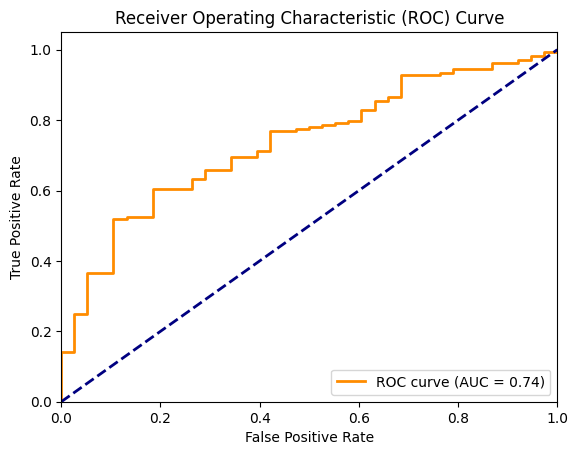

In [14]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### 3.2 Gains from Uncertainty-Aware Decoding

Lastly, we evaluate the gains from uncertainty-aware decoding (UAD) by measuring the factual precision over claims at various filtering thresholds. 

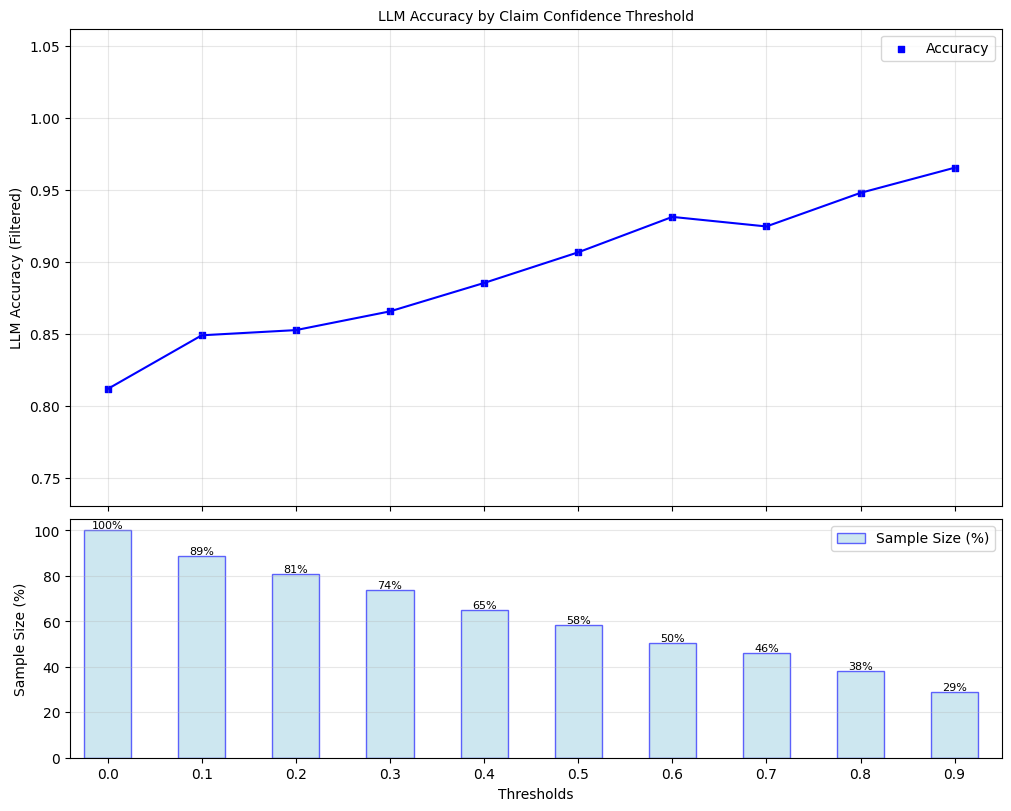

In [15]:
plot_model_accuracies(scores=all_claim_scores, correct_indicators=all_claim_grades, title=f"LLM Accuracy by Claim Confidence Threshold", display_percentage=True)

Since, we have selected a threshold of 0.35, we can measure LLM accuracy with and without UAD.

In [16]:
thresh = 0.35
filtered_grades, filtered_scores = [], []
for grade, score in zip(all_claim_grades, all_claim_scores):
    if score > thresh:
        filtered_grades.append(grade)
        filtered_scores.append(score)

print(f"Baseline LLM factual precision: {np.mean(all_claim_grades)}")
print(f"UAD-Improved LLM factual precision: {np.mean(filtered_grades)}")

Baseline LLM factual precision: 0.8118811881188119
UAD-Improved LLM factual precision: 0.8873239436619719


© 2025 CVS Health and/or one of its affiliates. All rights reserved.